In [1]:
import pandas as pd
import glob

model_rankings = 'monoT5'

all_model_dirs = glob.glob(f'../indexing/results/{model_rankings}/rankings/*')

In [50]:
model_dfs = []
for model_dir in all_model_dirs:
    all_csvs = glob.glob(f'{model_dir}/*.csv')
    model_name = model_dir.split('/')[-1]
    model_name = model_name.replace('instruct', 'no_prompt')

    print(model_name)
    model_df = []
    for csv in all_csvs:
        df = pd.read_csv(csv)
        df['docno'] = df['docno'].apply(lambda x: x.replace('instruct', 'no_prompt'))
        qid = df['qid'].values[0]
        query = df['query'].values[0]
        out_dict = {'qid': qid, 'query': query, 'model_name': model_name}
        try:
            llm_position = df[df['docno'].apply(lambda x: model_name in x)]['rank'].values[0]
            out_dict['llm_position'] = llm_position
            out_dict['weighted_llm_position'] = llm_position / df.shape[0]
            out_dict['llm_answer'] = df[df['docno'].apply(lambda x: model_name in x)]['text'].values[0]
            out_dict['total_number_of_results'] = df.shape[0]
            # calculate how often words in the query occur in the answer
            query_words = query.split()
            answer_words = out_dict['llm_answer'].split()
            num_query_words = len(query_words)
            num_answer_words = len(answer_words)
            num_matching_words = 0
            for query_word in query_words:
                for word in answer_words:
                    if query_word == word:
                        num_matching_words += 1
            out_dict['num_matching_words'] = num_matching_words

        except:
            print('No answer found for', qid , 'in', model_name)
            llm_position = df.shape[0]
            out_dict['llm_position'] = llm_position
            out_dict['weighted_llm_position'] = llm_position / df.shape[0]
            out_dict['llm_answer'] = ''
            out_dict['total_number_of_results'] = df.shape[0]
        
        model_df.append(out_dict)
    model_df = pd.DataFrame(model_df)
    model_df.sort_values(by=['qid'], inplace=True)
    model_dfs.append(model_df)



falcon40b_prompt
falcon7b_prompt
chatgpt
falcon7b_no_prompt
OA_LLama
falcon40b_no_prompt
No answer found for 132 in falcon40b_no_prompt
No answer found for 45 in falcon40b_no_prompt
No answer found for 112 in falcon40b_no_prompt
No answer found for 52 in falcon40b_no_prompt
No answer found for 51 in falcon40b_no_prompt


In [210]:
# generate dataframe with cols: model_name qid_1, qid_2...
# rows: llm_position, weighted_llm_position, llm_answer, total_number_of_results
# for each model
all_qids_df = []
for model_df in model_dfs:
    model_name = model_df['model_name'].values[0]
    out_dict = {'model_name': model_name}
    for qid in model_df['qid'].unique():
        out_dict[f'qid_{qid}'] = model_df[model_df['qid'] == qid]['weighted_llm_position'].values[0]
    all_qids_df.append(pd.DataFrame(out_dict, index=[0]))

# append max_num_results for each qid
# model_df = model_dfs[0]
# out_dict = {'model_name': 'max_num_results'}
# for qid in model_df['qid'].unique():
#     out_dict[f'qid_{qid}'] = model_df[model_df['qid'] == qid]['total_number_of_results'].values[0]
# all_qids_df.append(pd.DataFrame(out_dict, index=[0]))

all_qids_df = pd.concat(all_qids_df, ignore_index=True)

In [211]:
all_qids_df

,model_name,qid_1,qid_8,qid_22,qid_35,qid_45,qid_51,qid_52,qid_53,qid_54,...,qid_117,qid_118,qid_119,qid_121,qid_123,qid_126,qid_127,qid_130,qid_131,qid_132
0,falcon40b_prompt,0.0,0.000000,0.044,0.019355,0.000000,0.0,0.000000,0.0,0.004065,...,0.072581,0.000000,0.112426,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.000
1,falcon7b_prompt,0.0,0.000000,0.004,0.000000,0.007937,0.0,0.000000,0.0,0.004065,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
2,chatgpt,0.0,0.004237,0.000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.672840,0.000000,0.151515,0.000000,0.035294,0.000
3,falcon7b_no_prompt,0.0,0.000000,0.060,0.012903,0.007937,0.0,0.057895,0.0,0.000000,...,0.008065,0.887892,0.000000,0.000000,0.037037,0.521368,0.000000,0.000000,0.000000,0.848
4,OA_LLama,0.0,0.004237,0.004,0.000000,0.777778,0.0,0.000000,0.0,0.024390,...,0.000000,0.044843,0.940828,0.584270,0.006173,0.000000,0.272727,0.043478,0.000000,0.944
5,falcon40b_no_prompt,0.0,0.000000,0.000,0.000000,1.000000,1.0,1.000000,0.0,0.000000,...,0.056452,0.811659,0.000000,0.151685,0.000000,0.658120,0.000000,0.000000,0.000000,1.000


In [214]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
model_color_dict = {}
for model_df in model_dfs:
    model_name = model_df['model_name'].values[0]
    model_color_dict[model_name] = colors.pop(0)

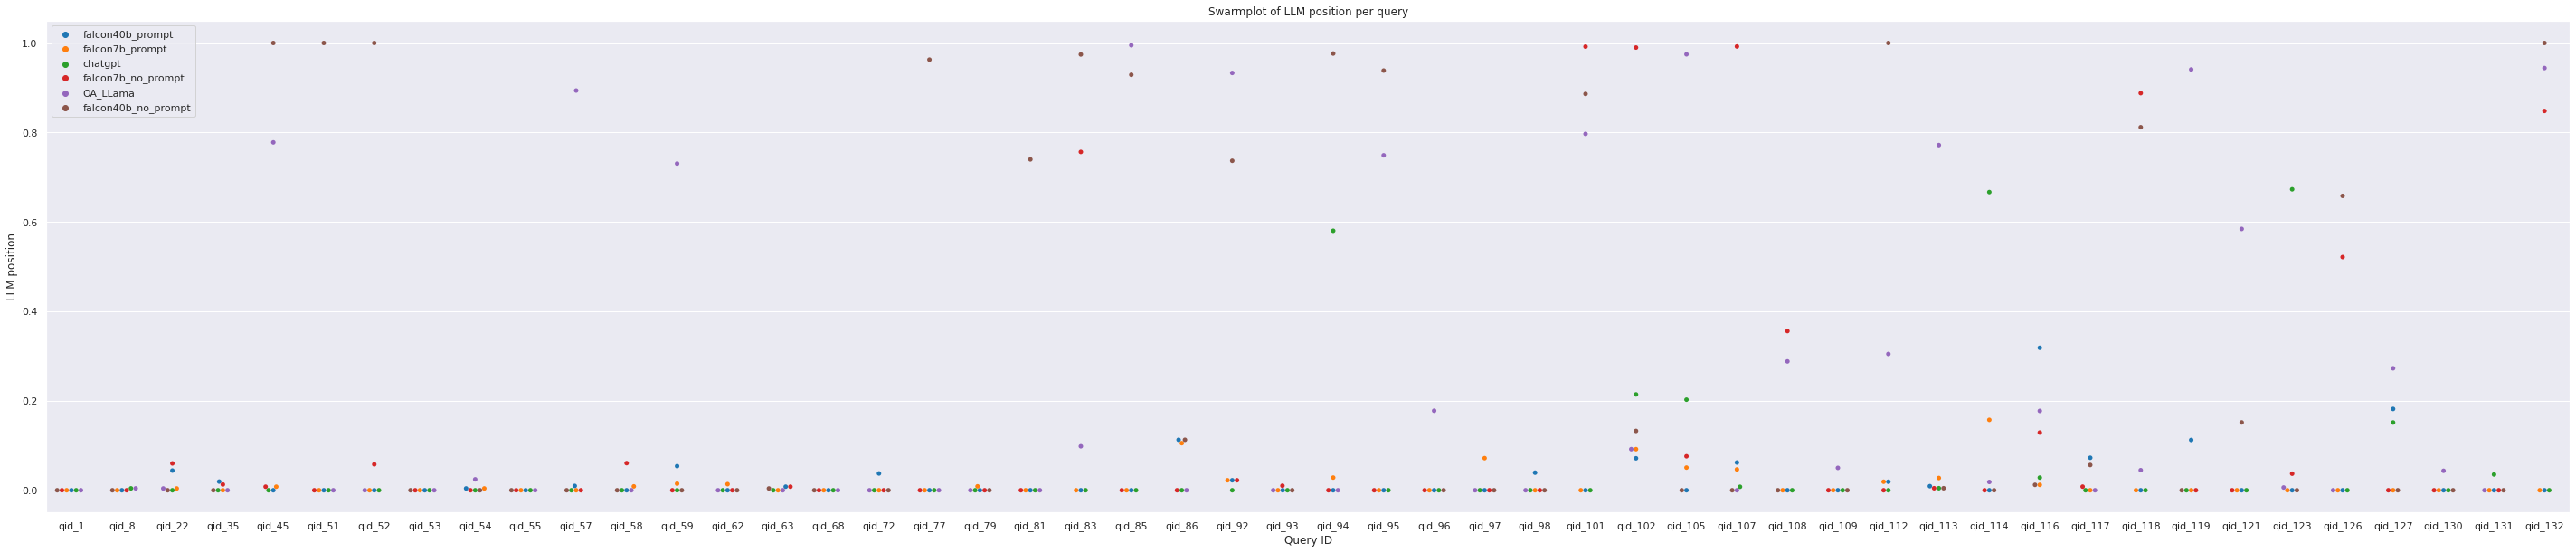

In [216]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

plt.figure(figsize=(50,10))

# Create a DataFrame with the data in long format
data = all_qids_df.melt(var_name='Query ID', value_name='LLM position', id_vars=['model_name'])
data['color'] = data['model_name'].apply(lambda x: model_color_dict[x])
# Create a swarmplot with the data, colored by model_name
sns.swarmplot(x='Query ID', y='LLM position', data=data, palette=model_color_dict.values(), hue='model_name', size=5)


# Add legend for max_num_results and model_name
# black_patch = mlines.Line2D([], [], color='black', marker='x', linestyle='None', markersize=10, label='max_num_results')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles= handles, labels=labels)

x_labels = all_qids_df.columns.to_list()[1:]
plt.xticks(range(len(x_labels)), x_labels)
plt.title('Swarmplot of LLM position per query')
plt.ylabel('LLM position')
plt.xlabel('Query ID')

plt.show()

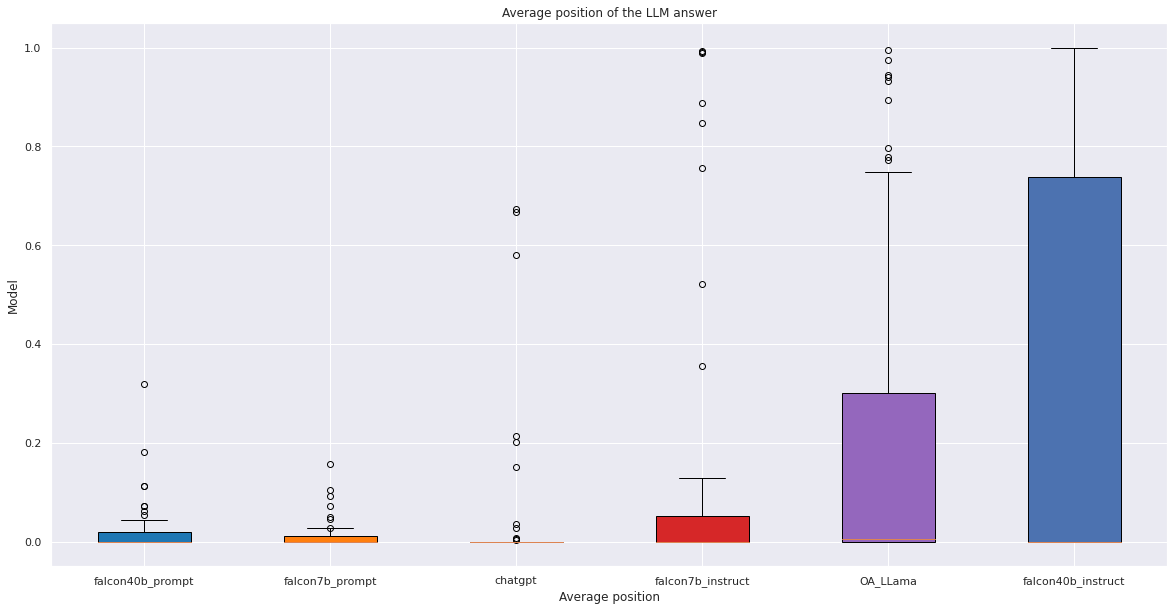

In [48]:
box_plot_data = []
for model_df in model_dfs:
    box_plot_data.append(model_df['weighted_llm_position'].values)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

bp = ax.boxplot(box_plot_data, patch_artist=True)
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# add model names
ax.set_xticklabels([model_df['model_name'].values[0] for model_df in model_dfs])

plt.title('Average position of the LLM answer')
plt.xlabel('Average position')
plt.ylabel('Model')
plt.show()


In [47]:
# get worst answers from chatgpt
chatgpt_df = model_dfs[2]
chatgpt_df.sort_values(by=['weighted_llm_position'], inplace=True, ascending=False)
chatgpt_df.head(10)

,qid,query,model_name,llm_position,weighted_llm_position,llm_answer,total_number_of_results,num_matching_words
11,123,hypothyroidism symptoms,chatgpt,109,0.672840,1. Fatigue and weakness\n2. Weight gain or dif...,162,0
24,114,borderline personality disorder symptoms,chatgpt,72,0.666667,1. Intense and unstable emotional experiences ...,108,0
38,94,When will I start to feel better with multiple...,chatgpt,123,0.580189,"As an AI language model, I do not have access ...",212,10
44,102,randomly gotten eczema,chatgpt,21,0.214286,"As an AI language model, I cannot have eczema ...",98,1
14,105,wisdom tooth cuts gum pain,chatgpt,16,0.202532,"As an AI language model, I cannot be qualified...",79,3
3,127,glasses for computer,chatgpt,10,0.151515,"As an AI language model, I do not have eyes no...",66,12
41,131,exercises for better posture,chatgpt,3,0.035294,1. Shoulder blade squeeze: Sit up straight and...,85,8
9,116,outcome prostate cancer,chatgpt,7,0.028226,"As an AI language model, I cannot have a perso...",248,19
46,107,medication adhd anxiety,chatgpt,1,0.007752,"As a language model AI, I cannot provide medic...",129,2
40,113,asthma and covid,chatgpt,1,0.004566,"As an AI language model, I don't have personal...",219,14


In [38]:
# calculate the average position of the LLM answer, number of top answers

averages = []
for model in model_dfs:
    out_dict = {}
    out_dict['model_name'] = model['model_name'].values[0]
    out_dict['average_llm_position'] = model['llm_position'].mean()
    out_dict['average_weighted_llm_position'] = model['weighted_llm_position'].mean().round(3)
    out_dict['top_answers'] = model[model['llm_position'] == 0].shape[0]
    out_dict['average_number_of_query_words_repeated_in_answer'] = model['num_matching_words'].mean().round(3)
    averages.append(out_dict)

averages = pd.DataFrame(averages)
averages.sort_values(by=['average_llm_position'], inplace=True)
averages

,model_name,average_llm_position,average_weighted_llm_position,top_answers,average_number_of_query_words_repeated_in_answer
1,falcon7b_prompt,2.06,0.014,32,8.880
0,falcon40b_prompt,4.28,0.024,32,5.820
2,chatgpt,7.28,0.051,39,11.180
3,falcon7b_instruct,20.18,0.137,29,53.560
4,OA_LLama,38.74,0.234,23,7.120
5,falcon40b_instruct,53.00,0.282,28,4.267


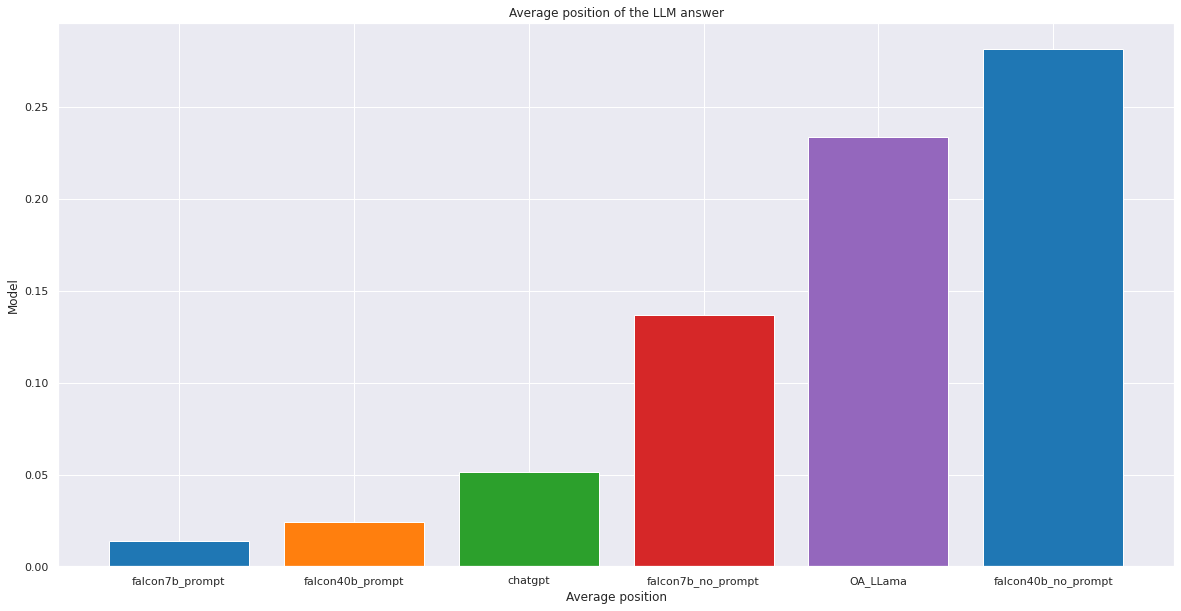

In [30]:
# visualize the average position of the LLM answer 

import matplotlib.pyplot as plt
# rename falcon*_instruct to falcon*_no_prompt

plt.figure(figsize=(20, 10))
plt.bar(averages['model_name'], averages['average_weighted_llm_position'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.title('Average position of the LLM answer')
plt.xlabel('Average position')
plt.ylabel('Model')
plt.show()

In [ ]:
# visualize the average llm position per query

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
